In [7]:
from pathlib import Path
import os
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
import statkit
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import pylab
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.calibration import calibration_curve
import seaborn as sns
from typing import List, Tuple
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, r2_score


sns.set_theme()

## Predicting Numerical Values with Machine Learning

- MLR
- Lasso regression
- KNN
- Random Forest
- XGBoost

In [2]:
df = pd.read_csv('Group1DatasetCleaned.csv')

# Define initial dropList for essential columns to drop
dropList = ['Life expectancy at birth, total (years)', 'CountryShortName', 'Year']

# Identify columns that contain "male" or "female" (ignoring case)
cols_to_drop = [col for col in df.columns if 'male' in col.lower() or 'female' in col.lower()]

# Combine the initial dropList with the columns identified by the keyword search
all_drop_columns = list(set(dropList + cols_to_drop))

# Create predictor (X) and target (Y) variables
X = df.drop(all_drop_columns, axis=1)
Y = df['Life expectancy at birth, total (years)']

# Calculate VIF for each numerical feature in X
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [round(variance_inflation_factor(X.values, i), 4) for i in range(X.shape[1])]

# Sort VIF values in descending order
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Display the VIF DataFrame
print(vif_data)

                                               feature           VIF
135           Rural population (% of total population)  8.146188e+09
223  Self-employed, total (% of total employment) (...  5.057619e+09
138           Urban population (% of total population)  4.019897e+09
227  Wage and salaried workers, total (% of total e...  3.638540e+09
233                                  Region_South Asia  1.198707e+05
..                                                 ...           ...
200            Fuel imports (% of merchandise imports)  2.810200e+00
2    GOAL 10: Reduced Inequality (5 year moving ave...  2.650500e+00
16     Final consumption expenditure (annual % growth)  2.280000e+00
150  Tuberculosis treatment success rate (% of new ...  2.263400e+00
14   General government final consumption expenditu...  1.504800e+00

[239 rows x 2 columns]


In [3]:
def calculate_vif(df):
    """Calculate VIF for each column in a DataFrame."""
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df.values, i) for i in range(df.shape[1])
    ]
    return vif_data

def iterative_vif_drop(X, threshold=4):
    """
    Iteratively drops the column with the highest VIF above `threshold`,
    until all remaining columns have VIF <= threshold.
    """
    while True:
        vif_df = calculate_vif(X)
        max_vif = vif_df["VIF"].max()
        if max_vif > threshold:
            drop_col = vif_df.loc[vif_df["VIF"].idxmax(), "feature"]
            print(f"Dropping '{drop_col}' with VIF={max_vif:.2f}")
            X = X.drop(columns=[drop_col])
        else:
            break
    return X

# Example usage:
X_reduced = iterative_vif_drop(X, threshold=4)

# Then recalculate your VIFs:
final_vif = calculate_vif(X_reduced)
print(final_vif)

Dropping 'Rural population (% of total population)' with VIF=8146187922.29
Dropping 'Region_South Asia' with VIF=118152.98
Dropping 'GDP, PPP (current international $)' with VIF=52731.74
Dropping 'Prevalence of anemia among women of reproductive age (% of women ages 15-49)' with VIF=37497.29
Dropping 'Total greenhouse gas emissions excluding LULUCF (Mt CO2e)' with VIF=27389.07
Dropping 'GNI (current US$)' with VIF=18766.62
Dropping 'Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)' with VIF=11932.68
Dropping 'Domestic credit to private sector by banks (% of GDP)' with VIF=6977.20
Dropping 'Nitrous oxide (N2O) emissions (total) excluding LULUCF (Mt CO2e)' with VIF=4085.42
Dropping 'GDP (current US$)' with VIF=3701.91
Dropping 'Number of infant deaths' with VIF=3578.45
Dropping 'Wage and salaried workers, total (% of total employment) (modeled ILO estimate)' with VIF=2577.43
Dropping 'Labor force, total' with VIF=2041.97
Dropping 'Methane (CH4) emissions (total) excludin

In [4]:

# Convert data to float if necessary
X = X_reduced.astype(float)
Y = Y.astype(float)

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=135)

# Initialize and fit the StandardScaler on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Add a constant to account for the intercept in the regression model
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Fit the OLS model on the training set
model = sm.OLS(y_train, X_train_scaled).fit()
print(model.summary())

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test Mean Squared Error:", mse)
print("Test R-squared:", r2)


                                       OLS Regression Results                                      
Dep. Variable:     Life expectancy at birth, total (years)   R-squared:                       0.875
Model:                                                 OLS   Adj. R-squared:                  0.872
Method:                                      Least Squares   F-statistic:                     329.7
Date:                                     Wed, 09 Apr 2025   Prob (F-statistic):               0.00
Time:                                             17:55:13   Log-Likelihood:                -5774.3
No. Observations:                                     2308   AIC:                         1.165e+04
Df Residuals:                                         2259   BIC:                         1.193e+04
Df Model:                                               48                                         
Covariance Type:                                 nonrobust                                         


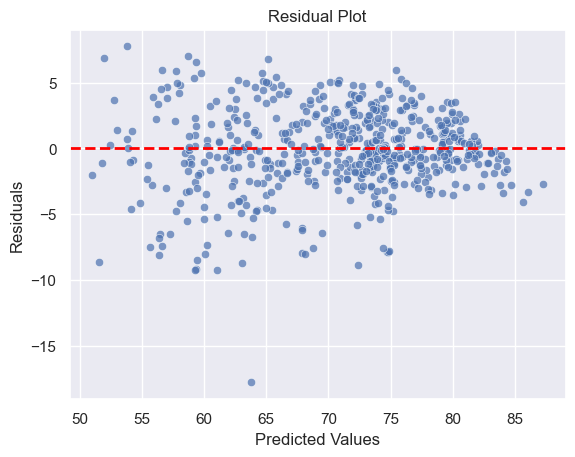

In [5]:
# Calculate residuals
residuals = y_test - y_pred

# Alternatively, using seaborn for a slightly enhanced plot:
sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [9]:
# -----------------------------------------------
# 2. Scikit-learn Linear Regression
# -----------------------------------------------
lr = LinearRegression()
lr.fit(X_train_sklearn, y_train)
y_pred_lr = lr.predict(X_test_sklearn)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("\nLinear Regression - Test MSE:", mse_lr, "R-squared:", r2_lr)

# -----------------------------------------------
# 3. Ridge Regression
# -----------------------------------------------
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_sklearn, y_train)
y_pred_ridge = ridge.predict(X_test_sklearn)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression - Test MSE:", mse_ridge, "R-squared:", r2_ridge)

# -----------------------------------------------
# 4. Lasso Regression
# -----------------------------------------------
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_sklearn, y_train)
y_pred_lasso = lasso.predict(X_test_sklearn)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression - Test MSE:", mse_lasso, "R-squared:", r2_lasso)

# -----------------------------------------------
# 5. ElasticNet Regression
# -----------------------------------------------
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic.fit(X_train_sklearn, y_train)
y_pred_elastic = elastic.predict(X_test_sklearn)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)
print("ElasticNet Regression - Test MSE:", mse_elastic, "R-squared:", r2_elastic)

# -----------------------------------------------
# 6. Decision Tree Regression
# -----------------------------------------------
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train_sklearn, y_train)
y_pred_tree = tree.predict(X_test_sklearn)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print("Decision Tree Regression - Test MSE:", mse_tree, "R-squared:", r2_tree)

# -----------------------------------------------
# 7. Random Forest Regression
# -----------------------------------------------
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_sklearn, y_train)
y_pred_rf = rf.predict(X_test_sklearn)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Regression - Test MSE:", mse_rf, "R-squared:", r2_rf)

NameError: name 'LinearRegression' is not defined